# Residuals for Cox regression model

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from lifelines import CoxPHFitter, KaplanMeierFitter

Read the data

In [2]:
DatOriginal = pd.read_csv("DatasetsMedicalResearch/Survival of multiple myeloma patients.dat", sep="\s+")
DatOriginal = DatOriginal.drop('patient', axis=1)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_4768/843039072.py:1: SyntaxWarning: invalid escape sequence '\s'
  DatOriginal = pd.read_csv("DatasetsMedicalResearch/Survival of multiple myeloma patients.dat", sep="\s+")


In [15]:
Model = CoxPHFitter().fit(DatOriginal, "time", "status", formula="bun+hb")

In [16]:
Model.print_summary()

<lifelines.CoxPHFitter: fitted with 48 total observations, 12 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 48
number of events observed = 36
   partial log-likelihood = -100.35
         time fit was run = 2024-09-22 03:58:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
bun        0.02      1.02      0.01            0.01            0.03                1.01                1.03
hb        -0.13      0.87      0.06           -0.26           -0.01                0.77                0.99

           cmp to     z      p  -log2(p)
covariate                               
bun          0.00  3.45 <0.005     10.78
hb           0.00 -2.18   0.03      5.09
---
Concordance = 0.67
Partial AIC = 204.70
log-likelihood ratio test = 13.98 on 2 df
-log2(p) of ll-ratio test = 10.08

Martingale, deviance, Schoenfeld and Scaled Schoenfeld residuals

In [17]:
rM = Model.compute_residuals(DatOriginal, 'martingale')
rD = Model.compute_residuals(DatOriginal, 'deviance')
rS = Model.compute_residuals(DatOriginal, 'schoenfeld')
rSS = Model.compute_residuals(DatOriginal, 'scaled_schoenfeld')

Cox-Snell residuals

In [18]:
rC = pd.DataFrame(
    {'time':rM['time'], 'status':rM['status'], 'cox_snell':-rM['martingale']+rM['status']}
)

Cox-Snell plot

In [19]:
# Fit Kaplan-Meier estimator for Cox-Snell residuals
Surv_rC = KaplanMeierFitter()
Surv_rC.fit(rC['cox_snell'], rC['status'])

# Estimate the cumulative hazard from the KM estimator
rC_KM = (-np.log(Surv_rC.survival_function_['KM_estimate'])).reset_index().drop_duplicates()
rC_KM = rC_KM.rename({'timeline':'cox_snell', 'KM_estimate':'cumulative_hazard'}, axis=1)
rC_KM = rC_KM.reset_index(drop=True)

rC_KM = pd.merge(rC, rC_KM)

Text(0, 0.5, 'Cumulative hazard of residuals')

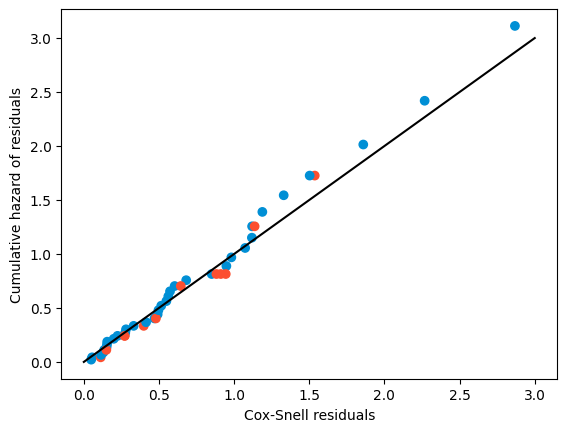

In [20]:
plt.scatter(
    rC_KM['cox_snell'],
    rC_KM['cumulative_hazard'],
    c=np.where(rC_KM['status'], '#008fd5', '#fc4f30')
)
plt.plot([0,3], [0,3], color='k')
plt.xlabel("Cox-Snell residuals")
plt.ylabel("Cumulative hazard of residuals")

Text(0, 0.5, 'log-cumulative hazard of residuals')

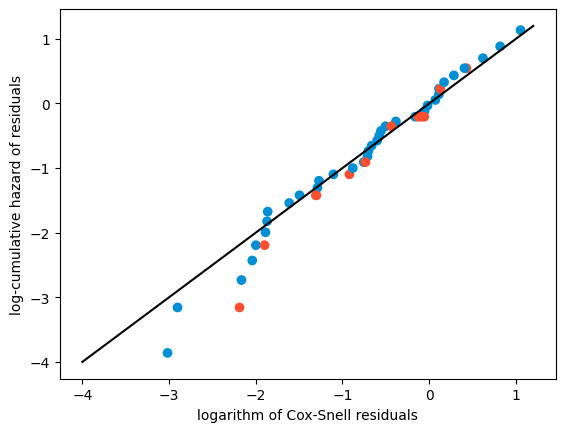

In [21]:
plt.scatter(
    np.log(rC_KM['cox_snell']),
    np.log(rC_KM['cumulative_hazard']),
    c=np.where(rC_KM['status'], '#008fd5', '#fc4f30')
)
plt.plot([-4,1.2], [-4,1.2], color='k')

plt.xlabel("logarithm of Cox-Snell residuals")
plt.ylabel("log-cumulative hazard of residuals")

Martingale and deviance residuals

Text(0, 0.5, 'Martingale residual')

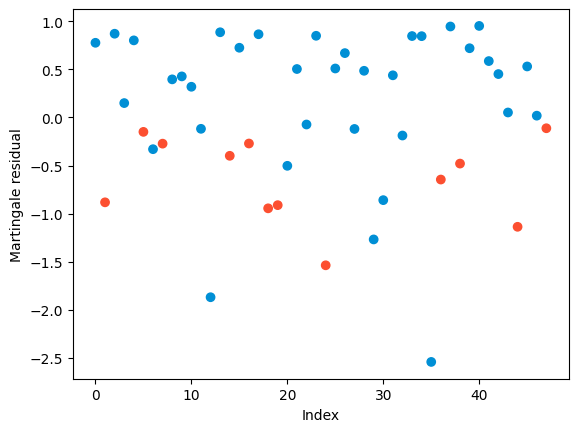

In [22]:
plt.scatter(
    rM.index,
    rM['martingale'],
    c=np.where(rM['status'], '#008fd5', '#fc4f30')
)
plt.xlabel("Index")
plt.ylabel("Martingale residual")

Text(0, 0.5, 'Deviance residual')

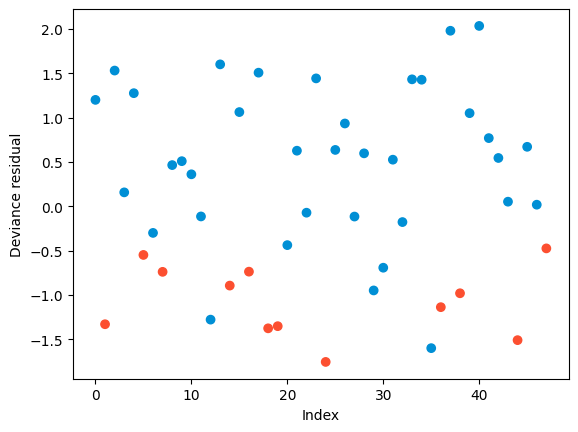

In [23]:
plt.scatter(
    rD.index,
    rD['deviance'],
    c=np.where(rD['status'], '#008fd5', '#fc4f30')
)
plt.xlabel("Index")
plt.ylabel("Deviance residual")

Text(0, 0.5, 'Deviance residual')

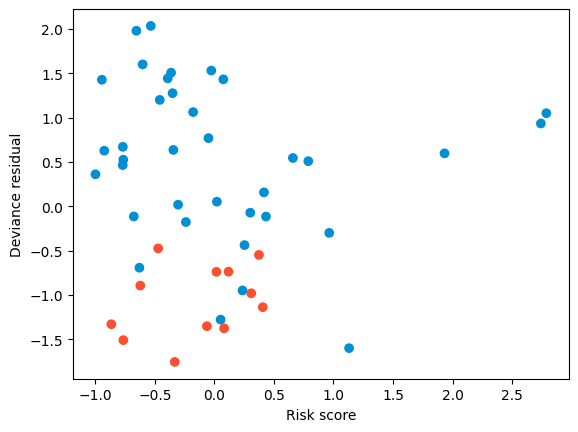

In [24]:
plt.scatter(
    Model.predict_log_partial_hazard(DatOriginal),
    rD['deviance'],
    c=np.where(rD['status'], '#008fd5', '#fc4f30')
)
plt.xlabel("Risk score")
plt.ylabel("Deviance residual")

Check proportional hazard assumption

We investigate if the assumption of proportional hazards is valid for the variable hb

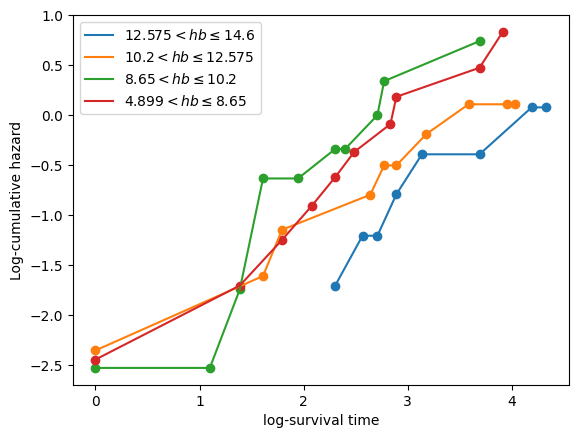

In [76]:
for q in DatOriginal["hb_quartiles"].unique():
    group = (DatOriginal["hb_quartiles"] == q)

    kmf = KaplanMeierFitter()
    kmf.fit(DatOriginal[group]['time'], DatOriginal[group]['status'])

    _ = (-np.log(kmf.survival_function_['KM_estimate'])).reset_index().drop_duplicates()

    plt.plot(
        np.log(_['timeline']),
        np.log(_['KM_estimate']),
        label=r"{}$<hb\leq${}".format(q.left, q.right)
    )
    plt.scatter(np.log(_['timeline']), np.log(_['KM_estimate']))

plt.xlabel("Log-survival time")
plt.ylabel("Log-cumulative hazard")
plt.legend()

In [77]:
Model.check_assumptions(DatOriginal)

Proportional hazard assumption looks okay.


[]


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.4000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4667)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8798)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8672)'>]]

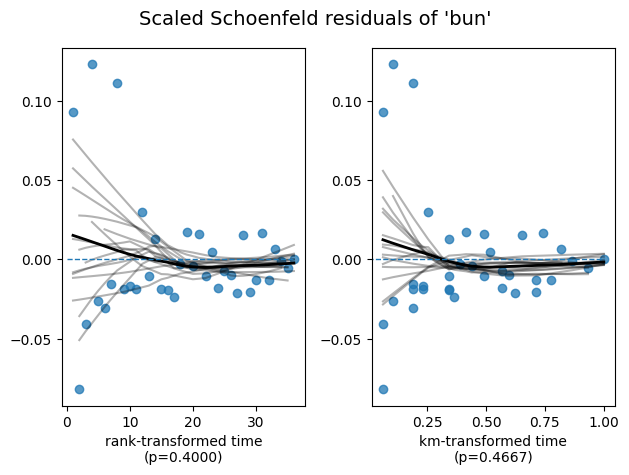

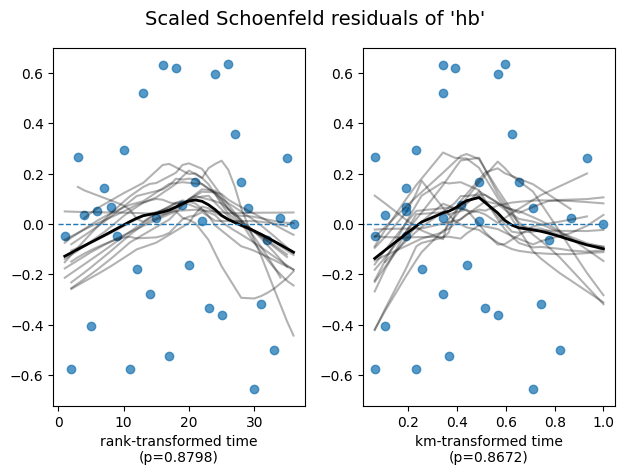

In [78]:
Model.check_assumptions(DatOriginal, plot_n_bootstraps=15, show_plots=True)